# 🍂 Season Tagging with MobileNetV2  
*Classifying fashion images into seasonal relevance for OmniRetail AI*

This notebook builds a product tagging model using transfer learning (MobileNetV2) on the DeepFashion dataset.

Our goal is to classify products into meaningful `season` categories (e.g., Summer, Winter, Spring), which will be used in downstream modules such as:

- 📢 Ad Copy Generation  
- 🧠 Purchase Intent Prediction  
- 🎯 Product Recommendation  

We apply label encoding, image preprocessing, data augmentation, and early stopping to train a compact CNN classifier with strong generalization. At the end, the trained model is exported for reuse in the AI pipeline.

## ✅ Imports & Path Setup

In [7]:
# Imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Relative Paths Setup
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

DATA_DIR = os.path.join(BASE_DIR, "data")
MODEL_DIR = os.path.join(BASE_DIR, "models")

RAW_DIR = os.path.join(DATA_DIR, "raw")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")

IMAGE_DIR = os.path.join(RAW_DIR, "images")
STYLES_CSV = os.path.join(RAW_DIR, "styles.csv")

## 🖼️ Load and Preprocess Images

To train a MobileNetV2 classifier, we:
- Read and resize up to 10,000 product images to 128x128 pixels
- Normalize RGB pixel values to the [0, 1] range
- Encode product category strings using `LabelEncoder`
- One-hot encode labels for softmax classification

This results in NumPy arrays suitable for input into a CNN model.

In [4]:
# Load data
df = pd.read_csv(STYLES_CSV)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


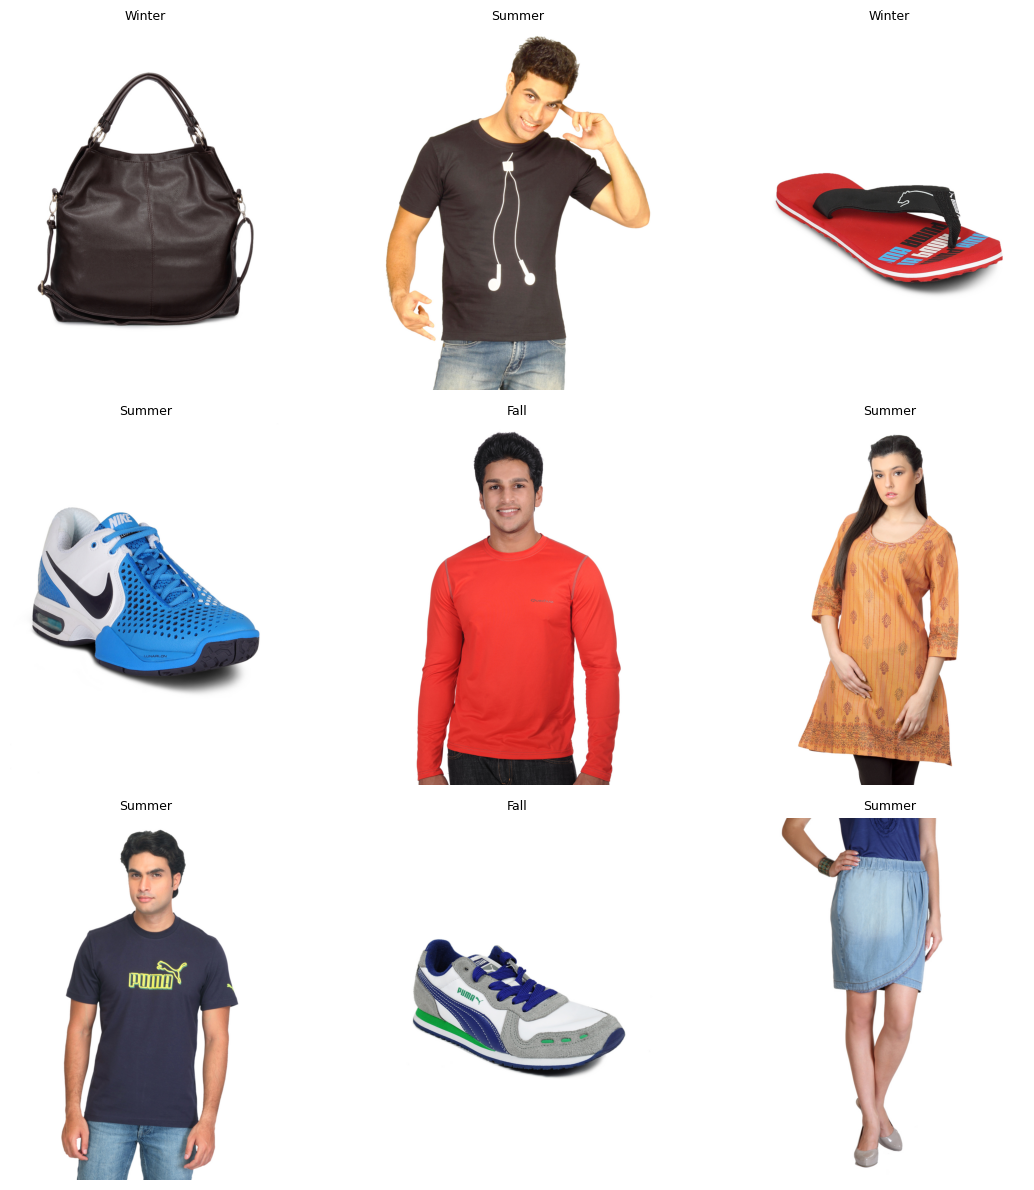

In [5]:
# Plot 9 random images with their season
sample_df = df.sample(9, random_state=42)

plt.figure(figsize=(12, 12))
for i, row in enumerate(sample_df.itertuples()):
    img_path = os.path.join(IMAGE_DIR, f"{row.id}.jpg")
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(row.season, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Load images
image_size = (128, 128)

image_data = []
labels = []

print("🧪 Loading images...")
for _, row in tqdm(df.iterrows(), total=10000):
    path = os.path.join(IMAGE_DIR, row['filename'])
    if os.path.exists(path):
        img = load_img(path, target_size=image_size)
        img_array = img_to_array(img)
        image_data.append(img_array)
        labels.append(row['season'])
    if len(image_data) >= 10000:  # Optional: Increase to 20000+ or remove limit to improve performance (GPU recommended)
        break

X = np.array(image_data) / 255.0  # Normalize

# Encode labels
y_raw = labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
y = to_categorical(y_encoded)
num_classes = y.shape[1]

print(f"✅ Processed {X.shape[0]} images into shape {X.shape[1:]}, with {num_classes} classes.")

🧪 Loading images...


100%|█████████▉| 9999/10000 [49:37<00:00,  3.36it/s]


✅ Processed 10000 images into shape (128, 128, 3), with 5 classes.


## 🎯 Train/Test Split

Split the preprocessed dataset into 80% training and 20% testing sets to evaluate model generalization.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🧠 Build Transfer Learning Model

We leverage **MobileNetV2**, a lightweight convolutional neural network pre-trained on ImageNet, to extract general-purpose visual features.  
Transfer learning allows us to reuse these features for our fashion product classification task without training from scratch.

**Architecture Summary:**
- Load MobileNetV2 (excluding its top classification layers)
- Freeze its convolutional base to retain learned features
- Add custom fully-connected layers to classify our `baseColour` categories
- Use `categorical_crossentropy` loss and `accuracy` for multi-class classification


In [10]:
# Load MobileNetV2 base (without top classification layers)
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze convolutional base

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🏋️ Train with Image Augmentation

To improve model generalization and reduce overfitting, we use **real-time image augmentation** during training. Images are augmented just before they are fed into the model and every training epoch may see slightly different versions of the same image.

Augmentation increases dataset diversity by applying small, randomized transformations, helping the model learn to recognize products under different conditions.

**Applied augmentations:**
- `rotation_range=10`: Rotates images up to ±10°
- `width_shift_range=0.1` / `height_shift_range=0.1`: Translates images horizontally/vertically by up to 10%
- `zoom_range=0.1`: Random zooms
- `horizontal_flip=True`: Mirrors images horizontally

We also use **early stopping**, which monitors validation loss and stops training if it doesn't improve after 5 epochs. This prevents overfitting and restores the best-performing model weights.


In [11]:
# Define real-time image augmentation strategy
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Train model
print("🚀 Training...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[early_stop]
)

🚀 Training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 200s 770ms/step - accuracy: 0.5100 - loss: 1.2132 - val_accuracy: 0.6160 - val_loss: 0.8381
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 722ms/step - accuracy: 0.6154 - loss: 0.8986 - val_accuracy: 0.6455 - val_loss: 0.8054
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 186s 746ms/step - accuracy: 0.6283 - loss: 0.8502 - val_accuracy: 0.6010 - val_loss: 0.8582
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 745ms/step - accuracy: 0.6342 - loss: 0.8493 - val_accuracy: 0.6600 - val_loss: 0.7901
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 725ms/step - accuracy: 0.6621 - loss: 0.7951 - val_accuracy: 0.6640 - val_loss: 0.7873
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 726ms/step - accuracy: 0.6576 - loss: 0.7747 - val_accuracy: 0.6650 - val_loss: 0.7783
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 169s 676ms/step - accuracy: 0.6676 - loss: 0.7828 - val_accuracy: 0.6590 - val_loss: 0.7974
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 180s 720ms/step - accuracy: 0.6588 -

## 📊 Evaluate Model Performance

After training, we evaluate the model’s generalization on the **held-out test set** using accuracy.

We also visualize the training and validation **loss** and **accuracy** curves to understand the model’s learning dynamics.

These plots help us assess:
- 📈 Whether the model is converging properly
- 📉 Whether overfitting is occurring (e.g., training accuracy improving while validation accuracy stalls or drops)

In [12]:
# Evaluate model on test set
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.2%}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 415ms/step - accuracy: 0.6542 - loss: 0.7852
✅ Test Accuracy: 66.50%


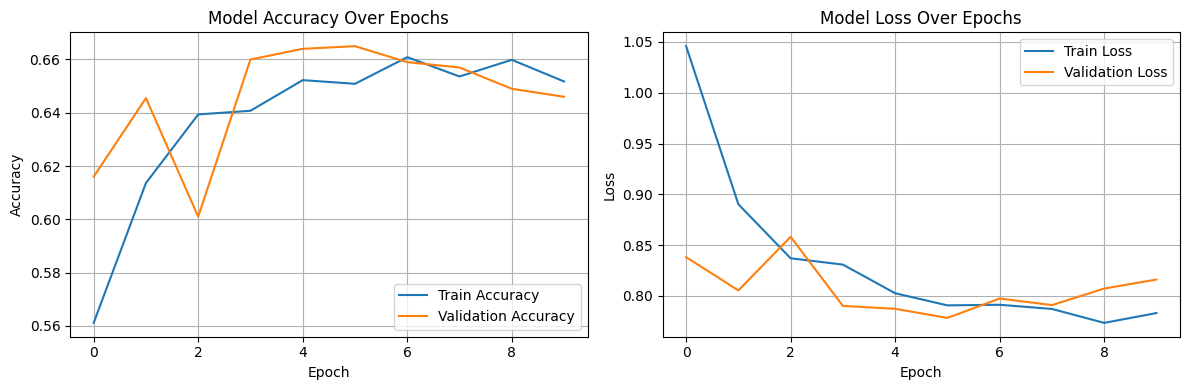

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 📈 Training History: Accuracy and Loss Curves

The following plots visualize the model’s performance over 10 training epochs:

- **Left Plot — Model Accuracy**  
  - Training accuracy (blue) steadily increases from ~56% to ~66%.  
  - Validation accuracy (orange) fluctuates slightly but remains close, ending around **65%**.  
  - The small gap between train and validation accuracy suggests **good generalization** with no strong signs of overfitting.

- **Right Plot — Model Loss**  
  - Training loss consistently decreases, showing smooth optimization.  
  - Validation loss stabilizes early and remains relatively flat after epoch 4–5, indicating convergence.

✅ The final **test accuracy is 66.50%**, demonstrating the model’s ability to learn meaningful seasonal patterns from visual features.  
Overall, this transfer learning approach performs well and is suitable for downstream applications like campaign timing and seasonal recommendations.

## 💾 Save Trained Model and Class Labels

After training, we export two key artifacts:

- The trained Keras model (`season_model_mobilenet.h5`)
- The list of season type classes (`season_tag_classes.csv`), needed to decode predicted class indices

These assets will be used in downstream modules such as:
- Ad copy generation
- Purchase intent prediction
- Personalized product recommendation

In [ ]:
# Save trained model
model.save(os.path.join(MODEL_DIR, "season_model_mobilenet.h5"))

# Save class label mapping for decoding predictions
pd.Series(le.classes_).to_csv(
    os.path.join(PROCESSED_DIR, "season_tag_classes.csv"),
    index=False
)

print("📦 Model and class labels saved to:")
print(f"→ Model: {os.path.join(MODEL_DIR, 'season_model_mobilenet.h5')}")
print(f"→ Classes: {os.path.join(PROCESSED_DIR, 'season_tag_classes.csv')}")

## ✅ Summary

- Trained a MobileNetV2-based CNN using transfer learning to classify ~10,000 fashion product images by **season** (e.g., Spring, Summer, Fall, Winter).

- Applied image augmentation and early stopping to improve generalization and prevent overfitting.

- Achieved **66.5% accuracy** on the test set — indicating the model has learned to capture seasonal visual cues in product design.

- Saved the trained model and season label mappings for downstream use in OmniRetail AI.

➡️ Next: use season predictions to support ad copy generation, targeted promotions, and seasonal campaign strategies.